Import necessary packages

In [ ]:
R = np.abs(rp_01+rp_12*np.exp(2*1j*k_z*d)/(1+rp_01*rp_12*np.exp(2*1j*k_z+d)))**2 

In [ ]:
rp_01 = (k_z/ε_0 - k_z/ε_1)/(k_z/ε_0 + k_z/ε_1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate

Declare the starting parameters as given by Heikki Rekola. The Basis for these parameters was that here we are interested in the optical wavlength range, and the outside of the range of 40-60 degrees there will not be any interesting results

In [2]:
#%% Givens

λ = np.linspace(.380, .700, 101) #Suggested range from advisor
#λ = 550 #placeholder value for testing
#θ = np.linspace(40, 60, 101) #Sugested range from advisor
θ = 50 #placeholder value for testing
ε0 = 8.8541878128e-12 #Farads per meter
c = 299792458 #Meters per second

k_z = 2*np.pi/λ
#Folowing varibles need definintion and just have place holder values
rp_01 = 1
rp_12 = 1
d     = 1

While for some materials it is possible to consider the refractive index ($n$) as a constant, in reality it varries with wavelength ($\lambda$). For the sake of consistency, all three materials in the setup will be treated the same. First, the refractive index is retreived from https://refractiveindex.info/ . Next the datframes are converted to numpy arrays, and then interpolated.

In [3]:
n_Au = pd.read_csv('https://refractiveindex.info/data_csv.php?datafile=data/main/Au/Johnson.yml')
n_BK7 = pd.read_csv('https://refractiveindex.info/data_csv.php?datafile=data/glass/schott/N-BK7.yml')
n_Air = pd.read_csv('https://refractiveindex.info/data_csv.php?datafile=data/other/mixed%20gases/air/Ciddor.yml')

n_Au = (n_Au.apply(pd.to_numeric, errors='coerce')).to_numpy()[:49,:49]
n_BK7 = (n_BK7.apply(pd.to_numeric, errors='coerce')).to_numpy()[:49,:49]
n_Air = (n_Air.apply(pd.to_numeric, errors='coerce')).to_numpy()[:49,:49]

n_Au = interpolate.interp1d(n_Au[:,0], n_Au[:,1])
n_BK7 = interpolate.interp1d(n_BK7[:,0], n_BK7[:,1])
n_Air = interpolate.interp1d(n_Air[:,0], n_Air[:,1])

If the refractive index is plotted across the optical spectrum, it becomes obvious why Au needed to be treated as a function rather than a constant.

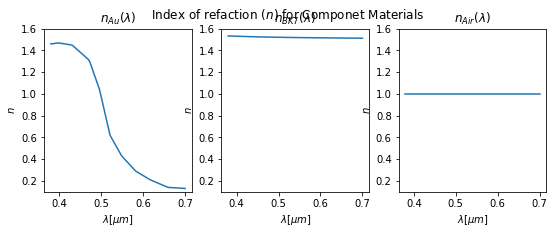

In [4]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = [9, 3])
plt.suptitle('Index of refaction ($n$) for Componet Materials')
axs[0].set(title='$n_{Au} (\lambda)$', xlabel='$\lambda [\mu m]$',
           ylabel = '$n$', ylim = (0.1, 1.6))
axs[0].plot(λ,n_Au(λ))

axs[1].set(title='$n_{BK7} (\lambda)$', xlabel='$\lambda [\mu m]$',
           ylabel = '$n$', ylim = (0.1, 1.6))
axs[1].plot(λ,n_BK7(λ))

axs[2].set(title='$n_{Air} (\lambda)$', xlabel='$\lambda [\mu m]$',
           ylabel = '$n$', ylim = (0.1, 1.6))
axs[2].plot(λ,n_Air(λ))

The next step in being able to use equation 2.17 is to be able to solve for the permeabilty for the materials in the system, and wave number in the medium. For finding the permeability, the relative permeabilty is multiplied by the relative permeability. Hecht Optics gives the condition that when the material is non-magnetic Maxwell's Realtion may be applied.

In [ ]:
ε_0 = ε0*n_BK7(λ)**2
ε_1 = ε0*n_Au(λ)**2
ε_2 = ε0*n_Air(λ)**2

Of course the wave vector will also be dependent on the refractive index and therefore the value must be found for each wavelength.

In [ ]:
k_z0 = 2*np.pi*BK7(λ)/λ
k_z1 = 2*np.pi*Au(λ)/λ
k_z2 = 2*np.pi*Air(λ)/λ

Bringing this all together in equation 2.17 yields

In [ ]:
rp_01 = (k_z0/ε_0 - k_z1/ε_1)/(k_z0/ε_0 + k_z1/ε_1)
rp_21 = (k_z1/ε_1 - k_z2/ε_2)/(k_z1/ε_1 + k_z2/ε_2)

With the help of equation 2.17, evertyting in equation 2.17 is now known, and $R(\lambda)$ may now be solved.

In [ ]:
R = np.abs(rp_01+rp_12*np.exp(2*1j*k_z1*d)/(1+rp_01*rp_12*np.exp(2*1j*k_z1+d)))**2 